In [1201]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from utils import get_data, get_probabilities, estimate_q_Z_given_A, get_probabilities_one_hot
from sklearn.decomposition import NMF  # Placeholder for volmin factorization
from volmin_nmf import *
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from scipy.optimize import nnls

In [1202]:
# ======================================================================================================================
#                                                     Flags
# ======================================================================================================================
'''
debug: Flag to print debug information such as the shape of the data, examples of data, confusion matrices etc.
summary: Flag to print summary information such as accuracy of models and the final q(Y|a)
'''
debug = True
summary = True

# ======================================================================================================================
#                                           Data Generation Parameters
# ======================================================================================================================
'''
These parameters are used to generate the data.
p_source: Probability of a sample being from the source domain
p_target: Probability of a sample being from the target domain
total: Total number of samples
factorisation_atol: Absolute tolerance for the factorisation
specific_a_index: Index of the specific A value to be used
num_classes_Y: Number of classes for Y
num_classes_W: Number of classes for W
num_features_Z: Number of features for Z
num_features_A: Number of features for A
'''
p_source = 0.8
p_target = 0.2
total = 10000
factorisation_atol = 1e-1
specific_a_index = 0  # First value of A
num_classes_Y = 2 
num_classes_W = 2
num_features_Z = 2
num_features_A = 3
num_epsilon = 2 # min(W_source.shape[1], Z_source.shape[1]) # Remember we need this to be less than the min of |W| and |Z|. Consider changing this as a hyperparameter

# ======================================================================================================================
#                                                NMF Parameters
# ======================================================================================================================
'''
Parameters for the NMF factorisation
nmf_method: Method for the NMF factorisation (currently uses https://github.com/bm424/mvcnmf/tree/master and activated by "volmin_2")
w_vol: Volume regularisation parameter
delta: Delta parameter for the NMF factorisation
n_iter: Number of iterations for the NMF factorisation
err_cut: Error cut-off for the NMF factorisation
'''
nmf_method = "volmin_2" 
w_vol = 0.01#0.1
delta = 1e-8
n_iter = 200000
err_cut = 1e-10

# ======================================================================================================================
#                                           Random Seed Initialisation
# ======================================================================================================================
np.random.seed(0)
torch.manual_seed(0)

In [1203]:
# ======================================================================================================================
#                                          Matrices for Data Generation
# ======================================================================================================================
'''
These matrices are used to generate the data.
theta_w_epsilon: Matrix for W given Epsilon
theta_z_epsilon: Matrix for Z given Epsilon
theta_a_z_epsilon: Matrix for A given Z and Epsilon
theta_y_a_w_epsilon: Matrix for Y given A, W and Epsilon

The dimensions of the variables are as follows:
W: 2D
Z: 2D
A: 3D
Y: 2D
Epsilon: 2D
'''

# theta_w_epsilon = torch.tensor([
#     [-2, 2],
#     [2, -2]
# ])

# theta_z_epsilon = torch.tensor([
#     [-2, 2],
#     [2, -2]
# ])

theta_w_epsilon = torch.tensor([
    [-2],
    [2]
])

theta_z_epsilon = torch.tensor([
    [-2],
    [2]
])

theta_a_z_epsilon = torch.tensor([
    [2.0, -2.0],  
    [-2.0, 2.0],
    [2.0, -2.0]
]) 

# 1x5 matrix concatenating 1 hot of w and a. Negate when epsilon is 1. a is 3D and w is 2D
theta_y_a_w_epsilon = torch.tensor([
    #[10, 3, -5, -3, 3]
    #[15, 10, -2, -3, 3]
    [10, 10, -2, -3, 3]
]) 


In [1204]:
# ======================================================================================================================
#                                          Data Generation Functions
# ======================================================================================================================

def get_tuple_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p=p_target):
    '''
    Generates a tuple of data points for the given parameters.

    Parameters:
    theta_w_epsilon: Matrix for W given Epsilon
    theta_z_epsilon: Matrix for Z given Epsilon
    theta_a_z_epsilon: Matrix for A given Z and Epsilon
    theta_y_a_w_epsilon: Matrix for Y given A, W and Epsilon
    p: Probability of a sample being from the target domain

    Returns:
    epsilon: Epsilon value via Bernoulli distribution
    z: Z value via Bernoulli distribution and sigmoid function
    w: W value via Bernoulli distribution and sigmoid function
    a: A value via theta_a_z_epsilon @ z or -theta_a_z_epsilon @ z depending on epsilon. One-hot encoded
    y: Y value via Bernoulli distribution and sigmoid function of theta_y_a_w_epsilon @ [w, a] or -theta_y_a_w_epsilon @ [w, a] depending on epsilon
    '''

    epsilon = torch.bernoulli(torch.tensor([p])).long() # (1,)
    epsilon_one_hot = torch.nn.functional.one_hot(torch.tensor(epsilon), num_classes=2).squeeze() # (1,2)

    # z = torch.bernoulli(torch.sigmoid(epsilon_one_hot @ theta_z_epsilon)).float().squeeze()
    # w = torch.bernoulli(torch.sigmoid(epsilon_one_hot @ theta_w_epsilon)).float().squeeze() 

    ### EXPT START ###
    # Calculate a single probability for z and w using sigmoid activation
    z_prob = torch.sigmoid(epsilon_one_hot @ theta_z_epsilon).squeeze()  # Now a single probability
    w_prob = torch.sigmoid(epsilon_one_hot @ theta_w_epsilon).squeeze()  # Now a single probability

    # Sample z and w using Bernoulli distribution
    z_sampled = torch.bernoulli(z_prob).long()  # Convert to long for one-hot encoding
    w_sampled = torch.bernoulli(w_prob).long()

    # Convert sampled z and w to one-hot vectors
    z = torch.nn.functional.one_hot(z_sampled, num_classes=2).float()
    w = torch.nn.functional.one_hot(w_sampled, num_classes=2).float()
    ### EXPT END ###


    # w given z and a should be perfect

    a_logits = epsilon * theta_a_z_epsilon.float() @ z.float() + (epsilon-1) * theta_a_z_epsilon.float() @ z.float() #epsilon is 0 or 1, theta_a_z_epsilon is 3x2, z is [2]. So result is 3x1
    a_prob = torch.softmax(a_logits, dim=0)  # Apply softmax to convert logits to probabilities
    if debug:
        print(a_prob)   
    a_category = torch.multinomial(a_prob, 1).squeeze()  # Sample from the categorical distribution
    a = torch.nn.functional.one_hot(a_category, num_classes=3).float()  # Convert to one-hot encoding
    if debug:
        print(a)
    # a = torch.bernoulli(torch.sigmoid(a_logits)).float().squeeze() # a is size 3

    # concatenate w and a
    # then similar but use different matrix and w,a instead of z
    wa = torch.cat((w, a), dim=0) # [5]

    y_logits = epsilon * theta_y_a_w_epsilon @ wa.long() + (epsilon-1) * theta_y_a_w_epsilon @ wa.long() # y is a function of a, w and epsilon from the graph
    #print(torch.sigmoid(y_logits))
    y = torch.bernoulli(torch.sigmoid(y_logits).squeeze()).float()

    return epsilon,z,w,a,y


def get_dataset_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p, total):
    '''
    Generates a dataset of data points for the given parameters, using the get_tuple_new function.

    Parameters:
    theta_w_epsilon: Matrix for W given Epsilon
    theta_z_epsilon: Matrix for Z given Epsilon
    theta_a_z_epsilon: Matrix for A given Z and Epsilon
    theta_y_a_w_epsilon: Matrix for Y given A, W and Epsilon
    p: Probability of a sample being from the target domain
    total: Total number of samples

    Returns:
    U: List of Epsilon values
    Z: List of Z values
    W: List of W values
    X: List of A values
    Y: List of Y values
    '''

    U,Z,W,X,Y = [],[],[],[],[]
    for _ in range(total):
        u,z,w,x,y = get_tuple_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p)
        U.append(u)
        Z.append(z)
        W.append(w)
        X.append(x)
        Y.append(y)

    return U,Z,W,X,Y


def get_data_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_source, p_target, total):
    '''
    Returns the source and target datasets for the given parameters.

    Parameters:
    theta_w_epsilon: Matrix for W given Epsilon
    theta_z_epsilon: Matrix for Z given Epsilon
    theta_a_z_epsilon: Matrix for A given Z and Epsilon
    theta_y_a_w_epsilon: Matrix for Y given A, W and Epsilon
    p_source: Probability of a sample being from the source domain
    p_target: Probability of a sample being from the target domain
    total: Total number of samples

    Returns:
    (Z_source, U_source, W_source, X_source, Y_source): Source dataset
    (Z_target, U_target, W_target, X_target, Y_target): Target dataset
    '''
    
    # Source distribution data
    U_source, Z_source, W_source, X_source, Y_source = get_dataset_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_source, total)
    
    # Target distribution data
    U_target, Z_target, W_target, X_target, Y_target = get_dataset_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_target, total)
    
    return (Z_source, U_source, W_source, X_source, Y_source), \
           (Z_target, U_target, W_target, X_target, Y_target)

In [1205]:
# Generate the source and target datasets
source_data, target_data = get_data_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_source, p_target, total)
Z_source, epsilon_source, W_source, A_source, Y_source = source_data
Z_target, epsilon_target, W_target, A_target, Y_target = target_data

/var/folders/tf/g242212x4tsbkxq6k9xkfvn80000gn/T/ipykernel_32114/867140292.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  epsilon_one_hot = torch.nn.functional.one_hot(torch.tensor(epsilon), num_classes=2).squeeze() # (1,2)


tensor([0.0177, 0.9647, 0.0177])
tensor([0., 1., 0.])
tensor([0.0177, 0.9647, 0.0177])
tensor([0., 1., 0.])
tensor([0.0177, 0.9647, 0.0177])
tensor([0., 1., 0.])
tensor([0.0177, 0.9647, 0.0177])
tensor([0., 1., 0.])
tensor([0.4955, 0.0091, 0.4955])
tensor([1., 0., 0.])
tensor([0.4955, 0.0091, 0.4955])
tensor([0., 0., 1.])
tensor([0.4955, 0.0091, 0.4955])
tensor([1., 0., 0.])
tensor([0.0177, 0.9647, 0.0177])
tensor([0., 1., 0.])
tensor([0.0177, 0.9647, 0.0177])
tensor([0., 1., 0.])
tensor([0.0177, 0.9647, 0.0177])
tensor([0., 1., 0.])
tensor([0.0177, 0.9647, 0.0177])
tensor([0., 1., 0.])
tensor([0.0177, 0.9647, 0.0177])
tensor([0., 1., 0.])
tensor([0.0177, 0.9647, 0.0177])
tensor([0., 1., 0.])
tensor([0.0177, 0.9647, 0.0177])
tensor([0., 1., 0.])
tensor([0.0177, 0.9647, 0.0177])
tensor([0., 1., 0.])
tensor([0.0177, 0.9647, 0.0177])
tensor([0., 1., 0.])
tensor([0.4955, 0.0091, 0.4955])
tensor([1., 0., 0.])
tensor([0.0177, 0.9647, 0.0177])
tensor([0., 1., 0.])
tensor([0.0177, 0.9647, 0.01

In [1206]:
# Split source data into training, validation, and test sets
A_train_val_source, A_test_source, Z_train_val_source, Z_test_source, W_train_val_source, W_test_source, Y_train_val_source, Y_test_source, epsilon_train_val_source, epsilon_test_source = train_test_split(
    A_source, Z_source, W_source, Y_source, epsilon_source, test_size=0.2, random_state=42)
A_train_source, A_val_source, Z_train_source, Z_val_source, W_train_source, W_val_source, Y_train_source, Y_val_source, epsilon_train_source, epsilon_val_source = train_test_split(
    A_train_val_source, Z_train_val_source, W_train_val_source, Y_train_val_source, epsilon_train_val_source, test_size=0.25, random_state=42)



In [1207]:
# Split target data into training, validation, and test sets
A_train_val_target, A_test_target, Z_train_val_target, Z_test_target, W_train_val_target, W_test_target, Y_train_val_target, Y_test_target, epsilon_train_val_target, epsilon_test_target = train_test_split(
    A_target, Z_target, W_target, Y_target, epsilon_target, test_size=0.2, random_state=42)
A_train_target, A_val_target, Z_train_target, Z_val_target, W_train_target, W_val_target, Y_train_target, Y_val_target, epsilon_train_target, epsilon_val_target = train_test_split(
    A_train_val_target, Z_train_val_target, W_train_val_target, Y_train_val_target, epsilon_train_val_target, test_size=0.25, random_state=42)


In [1208]:
# So the sets are of the form:
# Training: A_train_source
# Validation: A_val_source
# Test: A_test_source

In [1209]:
if debug:
    sum(Y_source)

In [1210]:
if debug:
    print("Y_source.shape", len(Y_source))
    print("W_source.shape", len(W_source))
    print("A_source.shape", len(A_source))
    print("Z_source.shape", len(Z_source))
    print("epsilon_source.shape", len(epsilon_source))

    print("Y_source", Y_source)
    print("W_source", W_source)
    print("A_source", A_source)
    print("Z_source", Z_source)
    print("epsilon_source", epsilon_source)

Y_source.shape 10000
W_source.shape 10000
A_source.shape 10000
Z_source.shape 10000
epsilon_source.shape 10000
Y_source [tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), ten

In [1211]:
sum_epsilon = np.sum(epsilon_source)
if debug:
    print("Sum of epsilon_source:", sum_epsilon.item())

sum_Y = np.sum(Y_source)
if debug:
    print("Sum of Y_source:", sum_Y.item())

Sum of epsilon_source: 7993
Sum of Y_source: 7986.0


In [1212]:
# =============================================================================
# Step 1: Estimate p(Y|Z,a) and p(W|Z,a)
# =============================================================================

# Train model to estimate p(Y|Z,a)
# By stacking with A, we condition on A by including all values of A in the input

# AMENDED TO USE TRAIN TEST SPLIT
ZA_source = np.hstack((Z_train_source, A_train_source)) 
# ZA_source = np.hstack((Z_source, A_source)) 


# if step1_debug:
#     print("ZA_source.shape", ZA_source.shape)  # Debug print statement
#     print("ZA_source", ZA_source)  # Debug print statement

############### LOGISTIC REGRESSION VERSION ###############

#model_Y = LogisticRegression(input_dim=ZA_source.shape[1], num_classes=2)
#model_Y.train(torch.tensor(ZA_source, dtype=torch.float32), torch.tensor(Y_source, dtype=torch.float32))

# model_Y = LogisticRegressionGD(input_dim=ZA_source.shape[1], num_classes=Y_source.shape[1])
# model_Y.train_model(torch.tensor(ZA_source, dtype=torch.float32), torch.tensor(Y_source, dtype=torch.float32), learning_rate=0.01, epochs=100, verbose=True)
# p_Y_given_ZA = get_probabilities(model_Y, Z_source, A_source)

In [1213]:
if debug:
    ZA_source

##### LOGISTIC REGRESSION #####
model_Y = SklearnLogisticRegression(max_iter=1000)
model_Y.fit(ZA_source, Y_train_source)

##### GRAIDENT BOOSTING #####
# model_Y = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=0)
# model_Y.fit(ZA_source, Y_train_source)

##### RANDOM FOREST #####
# model_Y = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
# model_Y.fit(ZA_source, Y_train_source)

##### NEURAL NETWORK #####
# model_Y = MLPClassifier(hidden_layer_sizes=(8, 4), max_iter=1000)
# model_Y.fit(ZA_source, Y_train_source)

if debug:
    print(ZA_source)
    print(Y_source)
Y_train_pred = model_Y.predict(ZA_source)
if debug:
    print("Y_train_pred",Y_train_pred)

Y_train_true = Y_train_source
accuracy_Y_train = np.mean(Y_train_pred == Y_train_source)
print(f"Accuracy of model_Y on training set: {accuracy_Y_train:.4f}")


[[0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 ...
 [1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0.]]
[tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.

In [1214]:
cm = confusion_matrix(Y_train_source, model_Y.predict(ZA_source))
if debug:
    print("Classification Report:")
    print(classification_report(Y_train_source, model_Y.predict(ZA_source)))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92      1192
         1.0       0.96      1.00      0.98      4808

    accuracy                           0.97      6000
   macro avg       0.98      0.93      0.95      6000
weighted avg       0.97      0.97      0.97      6000



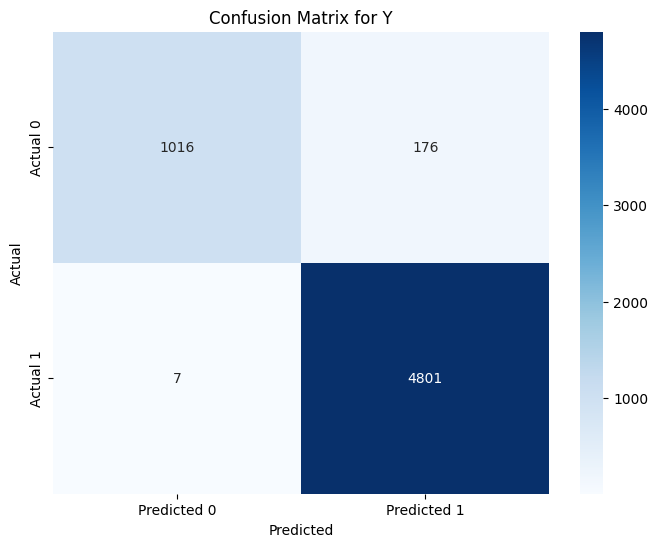

In [1215]:
if debug:    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Y')
    plt.show()

Y_val_pred: [1. 1. 1. ... 1. 1. 1.]
Accuracy of model_Y on validation set: 0.9710
Confusion Matrix (Validation):
[[ 335   57]
 [   1 1607]]
Classification Report (Validation):
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92       392
         1.0       0.97      1.00      0.98      1608

    accuracy                           0.97      2000
   macro avg       0.98      0.93      0.95      2000
weighted avg       0.97      0.97      0.97      2000



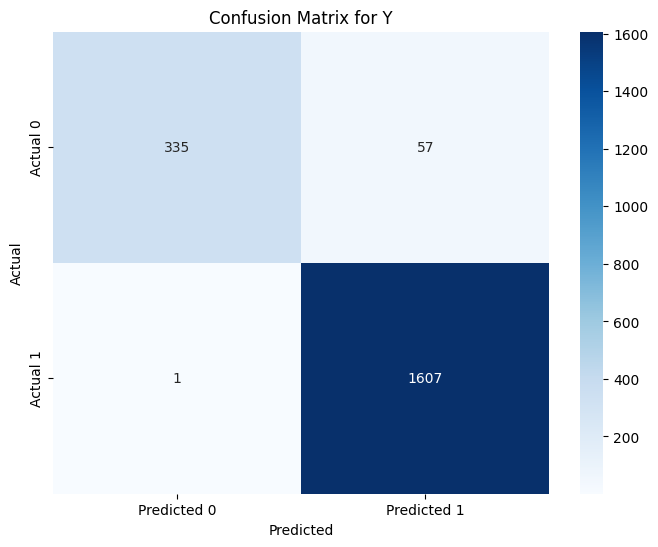

In [1216]:
# Confusion matrix for validation set

if debug:    
    # VALIDATION SET
    # Combine Z and A for the validation set
    ZA_source_validation = np.hstack((Z_val_source, A_val_source)) 

    # Predict Y on the validation set
    Y_val_pred = model_Y.predict(ZA_source_validation)
    print("Y_val_pred:", Y_val_pred)

    # True Y values for the validation set
    Y_val_true = Y_val_source

    # Calculate accuracy on the validation set
    accuracy_Y_val = np.mean(Y_val_pred == Y_val_true)
    print(f"Accuracy of model_Y on validation set: {accuracy_Y_val:.4f}")
    # Calculate confusion matrix for the validation set
    cm_val = confusion_matrix(Y_val_true, Y_val_pred)
    print("Confusion Matrix (Validation):")
    print(cm_val)

    # Print classification report for the validation set
    print("Classification Report (Validation):")
    print(classification_report(Y_val_true, Y_val_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Y')
    plt.show()

Y_test_pred: [1. 1. 1. ... 1. 1. 1.]
Accuracy of model_Y on test set: 0.9695
Confusion Matrix (Test):
[[ 370   60]
 [   1 1569]]
Classification Report (Test):
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92       430
         1.0       0.96      1.00      0.98      1570

    accuracy                           0.97      2000
   macro avg       0.98      0.93      0.95      2000
weighted avg       0.97      0.97      0.97      2000



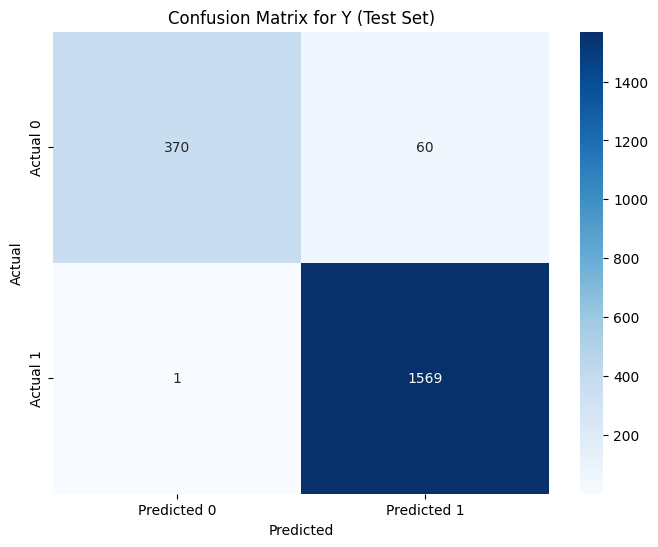

In [1217]:
# Confusion matrix for validation set

# Combine Z and A for the test set
ZA_source_test = np.hstack((Z_test_source, A_test_source))

# Predict Y on the test set
Y_test_pred = model_Y.predict(ZA_source_test)
if debug:
    print("Y_test_pred:", Y_test_pred)

# True Y values for the test set
Y_test_true = Y_test_source

# Calculate accuracy on the test set
accuracy_Y_test = np.mean(Y_test_pred == Y_test_true)
if debug:
    print(f"Accuracy of model_Y on test set: {accuracy_Y_test:.4f}")

if debug:
    # Calculate confusion matrix for the test set
    cm_test = confusion_matrix(Y_test_true, Y_test_pred)
    print("Confusion Matrix (Test):")
    print(cm_test)

    # Print classification report for the test set
    print("Classification Report (Test):")
    print(classification_report(Y_test_true, Y_test_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Y (Test Set)')
    plt.show()


In [1218]:
#convert to binary

def tensor_to_binary(tensor):
    return 1 if tensor[0] == 1 else 0

# Convert the list of tensors to a list of binary labels
binary_labels = [tensor_to_binary(t) for t in W_train_source]

# Convert to numpy array (optional)
binary_labels_array = np.array(binary_labels)

In [1219]:
############### LOGISTIC REGRESSION VERSION ###############
model_W= SklearnLogisticRegression(max_iter=1000)
model_W.fit(ZA_source, binary_labels_array)

W_train_pred = model_W.predict(ZA_source)
if debug:
    print("W_train_pred",W_train_pred)

W_train_true = W_source
accuracy_W_train = np.mean(W_train_pred == binary_labels_array)
print(f"Accuracy of model_W on training set: {accuracy_W_train:.4f}")

############### NEURAL NETWORK VERSION ###############

# Define and train the neural network
# input_dim = ZA_source.shape[1]
# model_W = SimpleNN(input_dim, num_classes_W)
# train_nn(model_W, torch.tensor(ZA_source, dtype=torch.float32), W_source_indices, learning_rate=0.001, epochs=500, batch_size=16)

# # Evaluate the model
# accuracy_nn = eval_nn(model_W, torch.tensor(ZA_source, dtype=torch.float32), W_source_indices)
# print(f'Accuracy of neural network model on training set: {accuracy_nn:.4f}')


W_train_pred [0 0 0 ... 1 0 0]
Accuracy of model_W on training set: 0.8627


Classification Report for W:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      4425
           1       0.87      0.56      0.68      1575

    accuracy                           0.86      6000
   macro avg       0.86      0.77      0.80      6000
weighted avg       0.86      0.86      0.85      6000



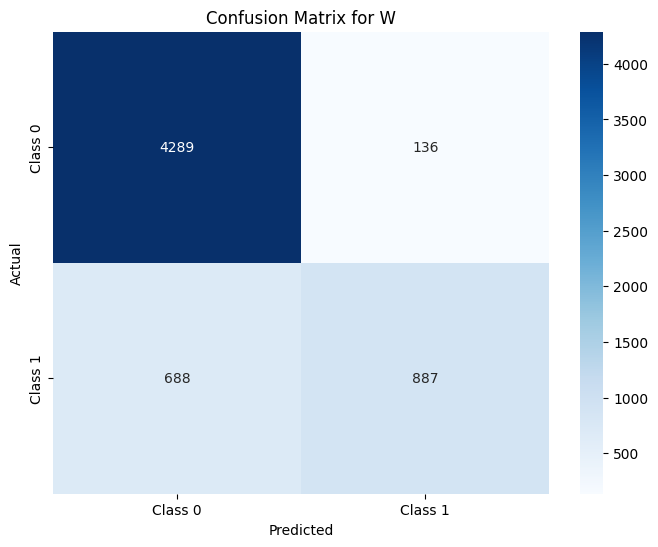

In [1220]:
cm_w = confusion_matrix(binary_labels_array, model_W.predict(ZA_source))
if debug:    
    print("Classification Report for W:")
    print(classification_report(binary_labels_array, model_W.predict(ZA_source)))

if debug:  
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_w, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for W')
    plt.show()

W_test_pred: [0 0 0 ... 0 0 0]
Accuracy of model_W on test set: 0.8700
Confusion Matrix (Test):
[[1408   39]
 [ 221  332]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.86      0.97      0.92      1447
           1       0.89      0.60      0.72       553

    accuracy                           0.87      2000
   macro avg       0.88      0.79      0.82      2000
weighted avg       0.87      0.87      0.86      2000



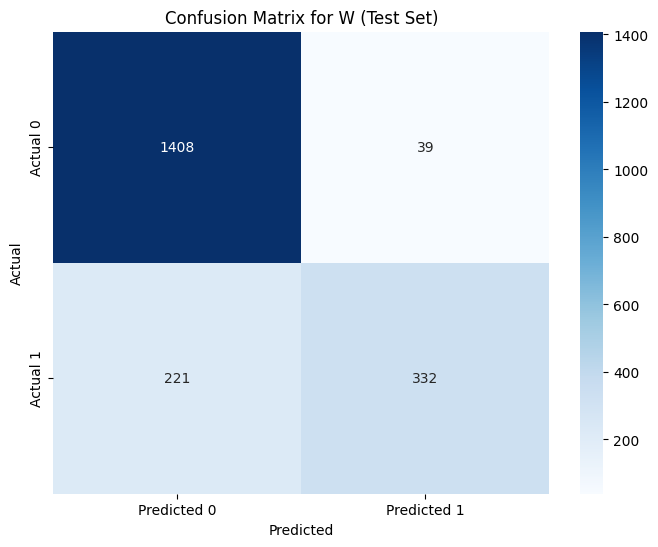

In [1221]:
# Test Set

# Predict Y on the test set
W_test_pred = model_W.predict(ZA_source_test)
if debug:
    print("W_test_pred:", W_test_pred)

# True Y values for the test set
W_test_true = np.array([tensor_to_binary(t) for t in W_test_source])

# Calculate accuracy on the test set
accuracy_W_test = np.mean(W_test_pred == W_test_true)
print(f"Accuracy of model_W on test set: {accuracy_W_test:.4f}")

if debug:
    # Calculate confusion matrix for the test set
    cm_test_W = confusion_matrix(W_test_true, W_test_pred)
    print("Confusion Matrix (Test):")
    print(cm_test_W)

    # Print classification report for the test set
    print("Classification Report (Test):")
    print(classification_report(W_test_true, W_test_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test_W, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for W (Test Set)')
    plt.show()


In [1222]:
if debug:
    np.array(binary_labels_array) # this is the true W
    np.array(epsilon_source).squeeze() # this is true epsilon
    count_W_0_eps_0 = np.sum((np.array(binary_labels_array) == 0) & (np.array(epsilon_train_source).squeeze() == 0))
    count_W_1_eps_0 = np.sum((np.array(binary_labels_array) == 1) & (np.array(epsilon_train_source).squeeze() == 0))
    count_W_0_eps_1 = np.sum((np.array(binary_labels_array) == 0) & (np.array(epsilon_train_source).squeeze() == 1))
    count_W_1_eps_1 = np.sum((np.array(binary_labels_array) == 1) & (np.array(epsilon_train_source).squeeze() == 1))
    print("Count W=0, epsilon=0:", count_W_0_eps_0)
    print("Count W=1, epsilon=0:", count_W_1_eps_0)
    print("Count W=0, epsilon=1:", count_W_0_eps_1)
    print("Count W=1, epsilon=1:", count_W_1_eps_1)

    # Total counts for eps = 0 and eps = 1
    total_eps_0 = np.sum(np.array(epsilon_train_source).squeeze() == 0)
    total_eps_1 = np.sum(np.array(epsilon_train_source).squeeze() == 1)

    # Calculate the probabilities
    P_W_0_given_eps_0 = count_W_0_eps_0 / total_eps_0 if total_eps_0 > 0 else 0
    P_W_1_given_eps_0 = count_W_1_eps_0 / total_eps_0 if total_eps_0 > 0 else 0
    P_W_0_given_eps_1 = count_W_0_eps_1 / total_eps_1 if total_eps_1 > 0 else 0
    P_W_1_given_eps_1 = count_W_1_eps_1 / total_eps_1 if total_eps_1 > 0 else 0
    print("P(W=0 | epsilon=0):", P_W_0_given_eps_0)
    print("P(W=1 | epsilon=0):", P_W_1_given_eps_0)
    print("P(W=0 | epsilon=1):", P_W_0_given_eps_1)
    print("P(W=1 | epsilon=1):", P_W_1_given_eps_1)


Count W=0, epsilon=0: 146
Count W=1, epsilon=0: 1042
Count W=0, epsilon=1: 4279
Count W=1, epsilon=1: 533
P(W=0 | epsilon=0): 0.12289562289562289
P(W=1 | epsilon=0): 0.877104377104377
P(W=0 | epsilon=1): 0.8892352452202826
P(W=1 | epsilon=1): 0.11076475477971737


In [1223]:
# First 5 entries of Z_source

if debug:
    Z_source[:5]

In [1224]:
# First 5 entries of A_source

if debug:
    A_source[:5]

In [1225]:
def get_probabilities(model, Z_source, A_source):
    '''
    Function to get the probabilities of Y given all possible Z and A and put them in a 3D array.
    '''

    # Convert lists of tensors to numpy arrays
    Z = np.array([z.numpy() for z in Z_source])
    A = np.array([a.numpy() for a in A_source])
    
    num_Z = Z.shape[1]
    num_A = A.shape[1]

    # Generate all possible one-hot vectors for Z and A
    possible_Z = np.eye(num_Z)
    possible_A = np.eye(num_A)
    
    probabilities = []
    
    for z in possible_Z:
        for a in possible_A:
            ZA = np.hstack((z.reshape(1, -1), a.reshape(1, -1)))
            # Flatten ZA for the MLPClassifier
            ZA_flat = ZA.flatten().reshape(1, -1)
            prob = model.predict_proba(ZA_flat)[0]
            probabilities.append(prob)
    
    probabilities = np.array(probabilities).reshape((num_Z, num_A, 2))
    
    return probabilities

In [1226]:
# Prints the probabilities of Y given Z and A, and probability of Y given Z and A for a specific A = a value

p_Y_given_ZA = get_probabilities(model_Y, Z_source, A_source)
print("This is p_Y_given_ZA, so for each possible Z and A")
print(p_Y_given_ZA)
p_Y_given_ZA_matrix = p_Y_given_ZA[:, specific_a_index, :]
print("")
print("")
print("This is p_Y_given_ZA, but for a specific A = a")
print(p_Y_given_ZA_matrix)

This is p_Y_given_ZA, so for each possible Z and A
[[[0.26685327 0.73314673]
  [0.86024722 0.13975278]
  [0.2867804  0.7132196 ]]

 [[0.0020793  0.9979207 ]
  [0.0340378  0.9659622 ]
  [0.0022965  0.9977035 ]]]


This is p_Y_given_ZA, but for a specific A = a
[[0.26685327 0.73314673]
 [0.0020793  0.9979207 ]]


In [1227]:
# Prints the probabilities of W given Z and A, and probability of W given Z and A for a specific A = a value

p_W_given_ZA = get_probabilities(model_W, Z_source, A_source)
print("This is p_W_given_ZA, so for each possible Z and A")
print(p_W_given_ZA)
p_W_given_ZA_matrix = p_W_given_ZA[:, specific_a_index, :]
print("")
print("")
print("This is p_W_given_ZA, but for a specific A = a")
print(p_W_given_ZA_matrix)

This is p_W_given_ZA, so for each possible Z and A
[[[0.61681092 0.38318908]
  [0.26223635 0.73776365]
  [0.65495166 0.34504834]]

 [[0.96431892 0.03568108]
  [0.85648413 0.14351587]
  [0.96957651 0.03042349]]]


This is p_W_given_ZA, but for a specific A = a
[[0.61681092 0.38318908]
 [0.96431892 0.03568108]]


In [1228]:
print("Step 1 done")

Step 1 done


In [1229]:
stacked_matrix = np.vstack((p_Y_given_ZA_matrix, p_W_given_ZA_matrix)) # this should be a |Y| x |Z| matrix stacked on top of a |W| x |Z| matrix (for specific a)
if debug:
    stacked_matrix.T

In [1230]:
# NMF factorisation

W, H = mvc_nmf(stacked_matrix.T, num_epsilon, w_vol, n_iter, err_cut) # Transpose the matrix to match the input format of the function

In [1231]:
if debug:
    print("W shape:", W.shape)
    print("H shape:", H.shape)
    print("W:", W)
    print("H:", H)

W shape: (4, 2)
H shape: (2, 2)
W: [[0.71130644 0.26651654]
 [0.96450597 0.00804998]
 [0.37640016 0.61113509]
 [0.0438198  0.95338501]]
H: [[0.         1.02049655]
 [1.00510276 0.        ]]


In [1232]:
p_Y_given_epsilon = W[:num_classes_Y, :] # |Y| x |\Epsilon| matrix for specific a, the first num_classes_Y rows #CHECK NUM_CLASSES_Y IS THE ONE
p_W_given_epsilon = W[num_classes_Y:, :] # |W| x |\Epsilon| matrix for specific a, the rest of the rows #CHECK NUM_CLASSES_Y IS THE ONE
p_epsilon_given_ZA = H # |\Epsilon| x |Z| matrix for specific a

In [1233]:
# Compares the p_W_given_epsilon from the matrix factorisation with the p_W_given_epsilon from the data
# They should somewhat match up to permutation

if debug:
    print("Comparison of p_W_given_epsilon from matrix factorisation vs p_w_given_epsilon from the data")
    print(p_W_given_epsilon)
    print("P(W=0 | epsilon=0):", P_W_0_given_eps_0)
    print("P(W=1 | epsilon=0):", P_W_1_given_eps_0)
    print("P(W=0 | epsilon=1):", P_W_0_given_eps_1)
    print("P(W=1 | epsilon=1):", P_W_1_given_eps_1)

Comparison of p_W_given_epsilon from matrix factorisation vs p_w_given_epsilon from the data
[[0.37640016 0.61113509]
 [0.0438198  0.95338501]]
P(W=0 | epsilon=0): 0.12289562289562289
P(W=1 | epsilon=0): 0.877104377104377
P(W=0 | epsilon=1): 0.8892352452202826
P(W=1 | epsilon=1): 0.11076475477971737


In [1234]:
if debug:
    # Print shapes to debug
    print("p_Y_given_epsilon shape:", p_Y_given_epsilon.shape)
    print("p_W_given_epsilon shape:", p_W_given_epsilon.shape)
    print("p_epsilon_given_ZA shape:", p_epsilon_given_ZA.shape)
    print("ZA_source shape:", ZA_source.shape)
    print("p_Y_given_epsilon:", p_Y_given_epsilon)
    print("p_W_given_epsilon (should be comparable to vec1 and vec2):", p_W_given_epsilon)
    #print("p_W_given_epsilon marginalised:", np.sum(p_W_given_epsilon, axis=1).reshape(-1, 1))
    # Verify the shapes of the factorized matrices
    assert p_Y_given_epsilon.shape == (num_classes_Y, num_epsilon), f"p_Y_given_epsilon shape mismatch: {p_Y_given_epsilon.shape}" #CHECK NUM_CLASSES_Y IS THE ONE
    assert p_W_given_epsilon.shape == (num_classes_W, num_epsilon), f"p_W_given_epsilon shape mismatch: {p_W_given_epsilon.shape}" #CHECK NUM_CLASSES_W IS THE ONE
    expected_shape = (num_epsilon, num_features_Z)  # Z_source[1] should be 4
    print("expected_shape", expected_shape)
    assert p_epsilon_given_ZA.shape == expected_shape, f"p_epsilon_given_ZA shape mismatch: {p_epsilon_given_ZA.shape}"
    print("Step 2: Factorization shapes are correct.")

# Verify reconstruction
reconstructed_stacked_matrix = np.dot(W, H)
if debug:
    print("stacked_matrix:", stacked_matrix)
    print("reconstructed_stacked_matrix:", reconstructed_stacked_matrix)
    assert np.allclose(stacked_matrix, reconstructed_stacked_matrix, atol = factorisation_atol), "Reconstructed matrix is not close to the original"
    print("Step 2: Reconstruction is correct.")

p_Y_given_epsilon shape: (2, 2)
p_W_given_epsilon shape: (2, 2)
p_epsilon_given_ZA shape: (2, 2)
ZA_source shape: (6000, 5)
p_Y_given_epsilon: [[0.71130644 0.26651654]
 [0.96450597 0.00804998]]
p_W_given_epsilon (should be comparable to vec1 and vec2): [[0.37640016 0.61113509]
 [0.0438198  0.95338501]]
expected_shape (2, 2)
Step 2: Factorization shapes are correct.
stacked_matrix: [[0.26685327 0.73314673]
 [0.0020793  0.9979207 ]
 [0.61681092 0.38318908]
 [0.96431892 0.03568108]]
reconstructed_stacked_matrix: [[0.26787651 0.72588577]
 [0.00809106 0.98427501]
 [0.61425357 0.38411506]
 [0.95824991 0.04471796]]
Step 2: Reconstruction is correct.


In [1235]:
print("Step 2 done")

Step 2 done


In [1236]:
ZA_train_target = np.hstack((Z_train_target, A_train_target))
if debug:
    ZA_train_target

In [1237]:
# Convert the list of tensors to a list of binary labels
binary_labels_target = [tensor_to_binary(t) for t in W_train_target]

# Convert to numpy array (optional)
binary_labels_target_array = np.array(binary_labels_target)

In [1238]:
model_q_W = SklearnLogisticRegression(max_iter=1000)
model_q_W.fit(ZA_train_target, binary_labels_target_array)

LogisticRegression(max_iter=1000)

In [1239]:
W_train_pred_target = model_q_W.predict(ZA_train_target)
if debug:   
    print("W_train_pred",W_train_pred_target)

W_train_true_target = W_train_target
accuracy_W_train_target = np.mean(W_train_pred_target == binary_labels_target_array)
print(f"Accuracy of model_W on training set: {accuracy_W_train_target:.4f}")

W_train_pred [1 1 1 ... 1 1 1]
Accuracy of model_W on training set: 0.8570


Classification Report for W:
              precision    recall  f1-score   support

           0       0.86      0.55      0.67      1582
           1       0.86      0.97      0.91      4418

    accuracy                           0.86      6000
   macro avg       0.86      0.76      0.79      6000
weighted avg       0.86      0.86      0.85      6000



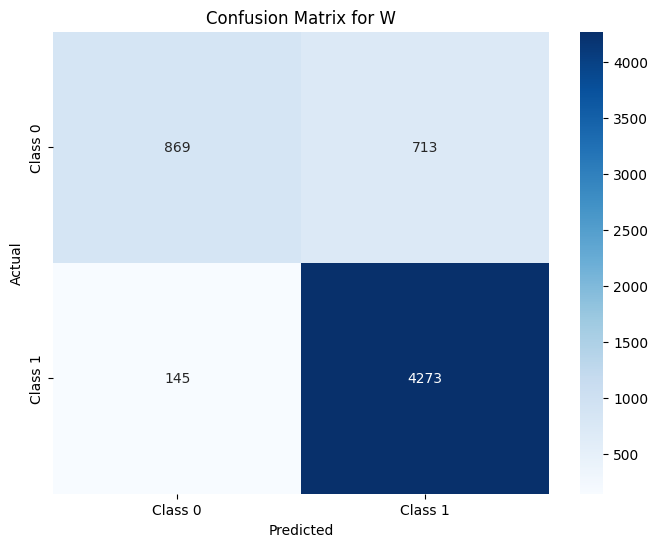

In [1240]:
# Confusion matrix for training set

cm_w_target = confusion_matrix(binary_labels_target_array, model_q_W.predict(ZA_train_target))
if debug:
    print("Classification Report for W:")
    print(classification_report(binary_labels_target_array, model_q_W.predict(ZA_train_target)))

if debug:
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_w_target, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for W')
    plt.show()

In [1241]:
print("This is q_W_given_ZA for all possible Z and A")
q_W_given_ZA = get_probabilities(model_q_W, Z_target, A_target)
q_W_given_ZA

This is q_W_given_ZA for all possible Z and A


array([[[0.03790464, 0.96209536],
        [0.14424423, 0.85575577],
        [0.0333411 , 0.9666589 ]],

       [[0.40330572, 0.59669428],
        [0.74304449, 0.25695551],
        [0.37174813, 0.62825187]]])

In [1242]:
print("Step 3 done")

Step 3 done


In [1243]:
# Now we extract q_W_given_ZA for specific a
print("This is q_W_given_ZA for all possible Z but for a specific A = a")
q_W_given_ZA_specific_a = q_W_given_ZA[:, specific_a_index, :]
q_W_given_ZA_specific_a

This is q_W_given_ZA for all possible Z but for a specific A = a


array([[0.03790464, 0.96209536],
       [0.40330572, 0.59669428]])

In [1244]:
if debug:
    p_W_given_epsilon

In [1245]:
if debug:    
    print(p_W_given_epsilon.shape)
    print(q_W_given_ZA_specific_a.shape)

(2, 2)
(2, 2)


In [1246]:
# TODO: CHECK IF TRANSPOSES NEEDED ETC
# We solve the linear equation by least squares
q_epsilon_given_Z_and_A, _, _, _ = np.linalg.lstsq(p_W_given_epsilon, q_W_given_ZA_specific_a, rcond=None) 

In [1247]:
print("Solve the linear equation q(W|Z,a) = p(W|\Epsilon)q(\Epsilon | Z,a) by least squares")
q_epsilon_given_Z_and_A #note I'm getting a negative value here

Solve the linear equation q(W|Z,a) = p(W|\Epsilon)q(\Epsilon | Z,a) by least squares


array([[-0.63340183,  1.66404396],
       [ 0.45213766,  0.54938582]])

In [1248]:
print("Step 4 done")

Step 4 done


In [1249]:
if debug:
    A_target[:5]

In [1250]:
if debug:
    Z_target[:5]

In [1251]:
# Convert the list of tensors to a list of binary labels
binary_labels_target_Z = [tensor_to_binary(t) for t in Z_train_target]

# Convert to numpy array (optional)
binary_labels_target_array_Z = np.array(binary_labels_target_Z)

In [1252]:
if debug:
    binary_labels_target_array_Z

In [1253]:
# smote = SMOTE(random_state=42)
# A_train_resampled, Z_train_resampled = smote.fit_resample(A_target, binary_labels_target_array_Z)

# class_weights = {
#     0: 1 / np.sum(binary_labels_target_array_Z == 0),
#     1: 1 / np.sum(binary_labels_target_array_Z == 1)
# }


# Train model to estimate q(Z|a)
model_q_Z = SklearnLogisticRegression(max_iter=1000)#, class_weight = class_weights)
model_q_Z.fit(A_train_target, binary_labels_target_array_Z)

# model_q_Z = SklearnLogisticRegression(max_iter=1000)#, class_weight = class_weights)
# model_q_Z.fit(A_target, binary_labels_target_array_Z)

# model_q_Z.fit(A_train_resampled, Z_train_resampled)

LogisticRegression(max_iter=1000)

In [1254]:
if debug:
    A_target[:5]

In [1255]:
Z_train_pred_target = model_q_Z.predict(A_train_target)
if debug:
    print("Z_target_pred",Z_train_pred_target)

Z_train_true_target = Z_train_target
accuracy_Z_train_target = np.mean(Z_train_pred_target == binary_labels_target_array_Z)
print(f"Accuracy of model on training set: {accuracy_Z_train_target:.4f}") 

Z_target_pred [1 1 0 ... 1 1 1]
Accuracy of model on training set: 0.7842


In [1256]:
Z_train_pred_target.sum()

5144

Classification Report for Z:
              precision    recall  f1-score   support

           0       0.67      0.36      0.47      1589
           1       0.80      0.94      0.86      4411

    accuracy                           0.78      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.77      0.78      0.76      6000



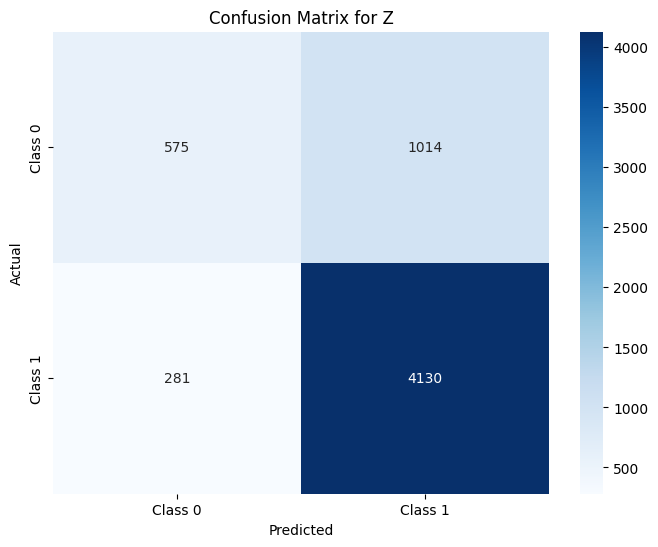

In [1257]:
cm_z_target = confusion_matrix(binary_labels_target_array_Z, model_q_Z.predict(A_train_target))
if debug:
    print("Classification Report for Z:")
    print(classification_report(binary_labels_target_array_Z, model_q_Z.predict(A_train_target)))

if debug:
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_z_target, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Z')
    plt.show()    

Z_test_pred_target [1 1 1 ... 1 1 0]
Accuracy of model on test set: 0.7830
Classification Report for Z:
              precision    recall  f1-score   support

           0       0.67      0.39      0.49       538
           1       0.80      0.93      0.86      1462

    accuracy                           0.78      2000
   macro avg       0.74      0.66      0.68      2000
weighted avg       0.77      0.78      0.76      2000



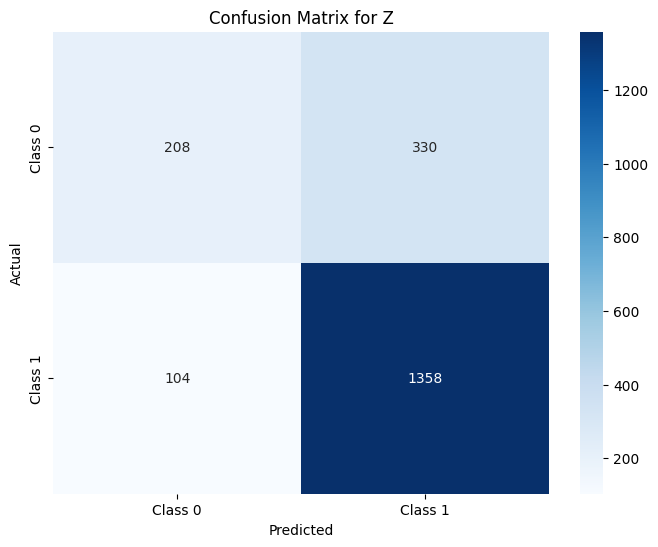

In [1258]:
# Confusion matrix for test set

Z_test_pred_target = model_q_Z.predict(A_test_target)
print("Z_test_pred_target",Z_test_pred_target)

Z_test_true_target = Z_test_target

# Convert the list of tensors to a list of binary labels
binary_labels_target_Z_test = [tensor_to_binary(t) for t in Z_test_target]

# Convert to numpy array (optional)
binary_labels_target_array_Z_test = np.array(binary_labels_target_Z_test)

accuracy_Z_test_target = np.mean(Z_test_pred_target == binary_labels_target_array_Z_test)
if debug:
    print(f"Accuracy of model on test set: {accuracy_Z_test_target:.4f}") 

cm_z_target_test = confusion_matrix(binary_labels_target_array_Z_test, model_q_Z.predict(A_test_target))
if debug:
    print("Classification Report for Z:")
    print(classification_report(binary_labels_target_array_Z_test, model_q_Z.predict(A_test_target)))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_z_target_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Z')
    plt.show()

In [1259]:
print("Step 5 done")

Step 5 done


In [1260]:
if debug:
    p_Y_given_epsilon

In [1261]:
if debug:
    q_epsilon_given_Z_and_A

In [1262]:
# Checking that A is indeed a one-hot encoding

# Assuming A_source is a list of tensors
A_source_np = np.array([a.numpy() for a in A_source])

# Find unique rows in A_source_np
unique_A = np.unique(A_source_np, axis=0)

if debug:
    # Print the number of unique rows
    print(f"Number of distinct entries in A_source: {len(unique_A)}")

    # Optionally, print the distinct entries
    print("Distinct entries in A_source:")
    print(unique_A)

Number of distinct entries in A_source: 3
Distinct entries in A_source:
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [1263]:
# Checking the distribution of A for Z = 0 and Z = 1

# Assuming A_source and Z_source are lists of tensors
A_source_np = np.array([a.numpy() for a in A_source])
Z_source_np = np.array([z.numpy() for z in Z_source])

if debug:
    # Check shapes to understand the data structure
    print("Shape of A_source_np:", A_source_np.shape)
    print("Shape of Z_source_np:", Z_source_np.shape)

# Ensure Z_source_np is flattened correctly if it's one-hot encoded or needs any transformation
# For example, if Z_source is 2D and needs to be combined into a single label per row:
if Z_source_np.shape[1] == 2:
    Z_source_np = np.argmax(Z_source_np, axis=1)

# Find unique entries in A_source
unique_A = np.unique(A_source_np, axis=0)

# Initialize a matrix to count occurrences of each A entry for Z = 0 and Z = 1
count_matrix = np.zeros((len(unique_A), 2))

# Populate the count matrix
for i, unique_a in enumerate(unique_A):
    for z_val in [0, 1]:
        count_matrix[i, z_val] = np.sum((A_source_np == unique_a).all(axis=1) & (Z_source_np == z_val))

# Convert the matrix to a DataFrame for better visualization
unique_A_labels = ['A' + str(i) for i in range(len(unique_A))]
count_df = pd.DataFrame(count_matrix, index=[str(list(a)) for a in unique_A], columns=['Z=0', 'Z=1'])

if debug:
    # Display the DataFrame
    print(count_df)


Shape of A_source_np: (10000, 3)
Shape of Z_source_np: (10000, 2)
                    Z=0     Z=1
[0.0, 0.0, 1.0]   536.0   233.0
[0.0, 1.0, 0.0]  1730.0  6781.0
[1.0, 0.0, 0.0]   496.0   224.0


In [1264]:
import numpy as np
import pandas as pd

# Assuming W_train_source and Z_train_source are lists of tensors
W_train_source_np = np.array([a.numpy() for a in W_train_source])
Z_train_source_np = np.array([z.numpy() for z in Z_train_source])

debug = True  # Set to True for debugging output

if debug:
    # Check shapes to understand the data structure
    print("Shape of W_train_source_np:", W_train_source_np.shape)
    print("Shape of Z_train_source_np:", Z_train_source_np.shape)

# Count unique occurrences in Z (as rows)
unique_Z, counts_Z = np.unique(Z_train_source_np, axis=0, return_counts=True)

# Count unique occurrences in W (as rows)
unique_W, counts_W = np.unique(W_train_source_np, axis=0, return_counts=True)

# Create DataFrames for visualization
Z_counts_df = pd.DataFrame({'Z_value': [str(list(z)) for z in unique_Z], 'Count': counts_Z})
W_counts_df = pd.DataFrame({'W_value': [str(list(w)) for w in unique_W], 'Count': counts_W})

if debug:
    # Display the counts
    print("Occurrences of each unique Z entry:")
    print(Z_counts_df)
    print("\nOccurrences of each unique W entry:")
    print(W_counts_df)


Shape of W_train_source_np: (6000, 2)
Shape of Z_train_source_np: (6000, 2)
Occurrences of each unique Z entry:
      Z_value  Count
0  [0.0, 1.0]   4351
1  [1.0, 0.0]   1649

Occurrences of each unique W entry:
      W_value  Count
0  [0.0, 1.0]   4425
1  [1.0, 0.0]   1575


In [1265]:
if debug:
    Z_target[:5]

In [1266]:
print("This is p(Y|\epsilon,a)")
print(p_Y_given_epsilon)
print("")

print("This is q(\epsilon|Z,a)")
print(q_epsilon_given_Z_and_A)
print("")

one_hot_specific_a = np.eye(len(A_source[0]))[specific_a_index].reshape(1, -1)
q_Z_given_A = model_q_Z.predict_proba(one_hot_specific_a)
print("This is q(Z|a)")
print(q_Z_given_A)

This is p(Y|\epsilon,a)
[[0.71130644 0.26651654]
 [0.96450597 0.00804998]]

This is q(\epsilon|Z,a)
[[-0.63340183  1.66404396]
 [ 0.45213766  0.54938582]]

This is q(Z|a)
[[0.68027372 0.31972628]]


In [1267]:
q_Y_given_A = p_Y_given_epsilon@(q_epsilon_given_Z_and_A@q_Z_given_A.T)
print("q_Y_given_a:", q_Y_given_A)

q_Y_given_a: [[0.20073895]
 [0.10145166]]


In [1268]:
q_Y_given_a_normalised = q_Y_given_A / np.sum(q_Y_given_A)
print("q_Y_given_a_normalised:", q_Y_given_a_normalised)

q_Y_given_a_normalised: [[0.66427923]
 [0.33572077]]


In [1269]:
if summary:
    print("Summary:")
    print(f"Accuracy of model_Y on training set: {accuracy_Y_train * 100:.2f}%")
    print(f"Accuracy of model_Y on test set: {accuracy_Y_test * 100:.2f}%")
    print(f"Accuracy of model_W on training set: {accuracy_W_train * 100:.2f}%")
    print(f"Accuracy of model_W on test set: {accuracy_W_test * 100:.2f}%")
    print(f"Accuracy of model_W on training set (target): {accuracy_W_train_target * 100:.2f}%")
    print(f"Accuracy of model_W on test set (target): {accuracy_W_test * 100:.2f}%")
    print(f"Accuracy of model_Z on training set (target): {accuracy_Z_train_target * 100:.2f}%")
    print(f"Accuracy of model_Z on test set (target): {accuracy_Z_test_target * 100:.2f}%")
    print("")
    print("q_Y_given_a:", q_Y_given_A)
    print("q_Y_given_a_normalised:", q_Y_given_a_normalised)

Summary:
Accuracy of model_Y on training set: 96.95%
Accuracy of model_Y on test set: 96.95%
Accuracy of model_W on training set: 86.27%
Accuracy of model_W on test set: 87.00%
Accuracy of model_W on training set (target): 85.70%
Accuracy of model_W on test set (target): 87.00%
Accuracy of model_Z on training set (target): 78.42%
Accuracy of model_Z on test set (target): 78.30%

q_Y_given_a: [[0.20073895]
 [0.10145166]]
q_Y_given_a_normalised: [[0.66427923]
 [0.33572077]]


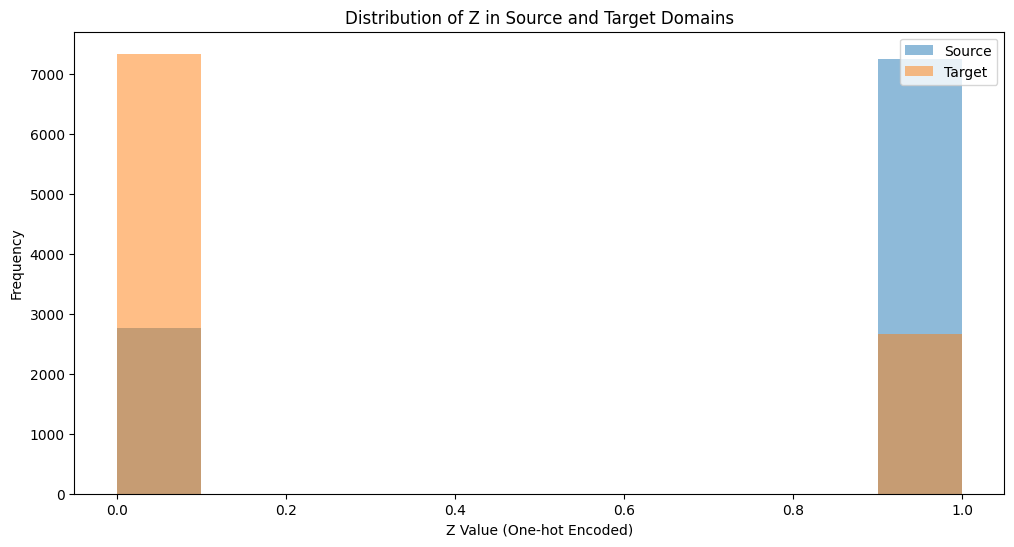

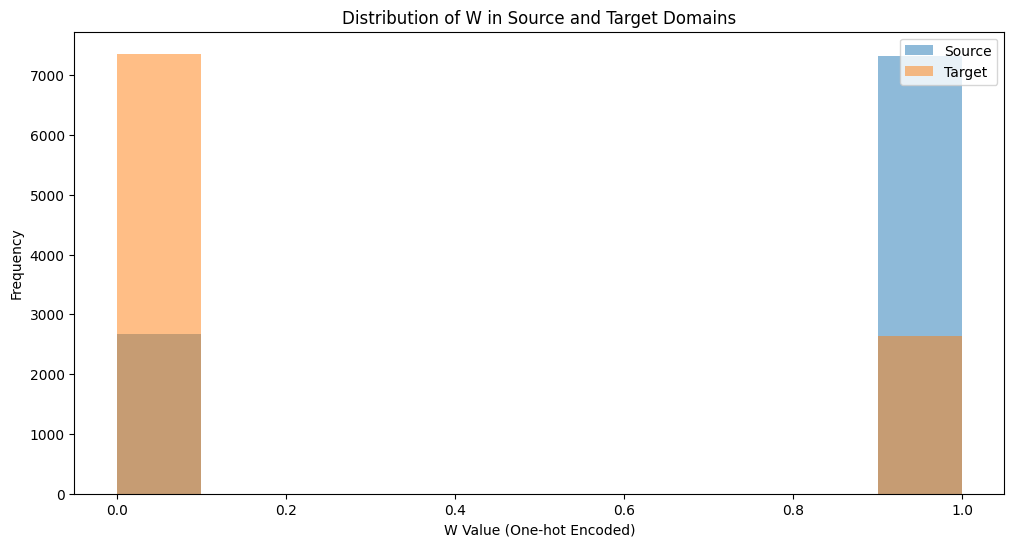

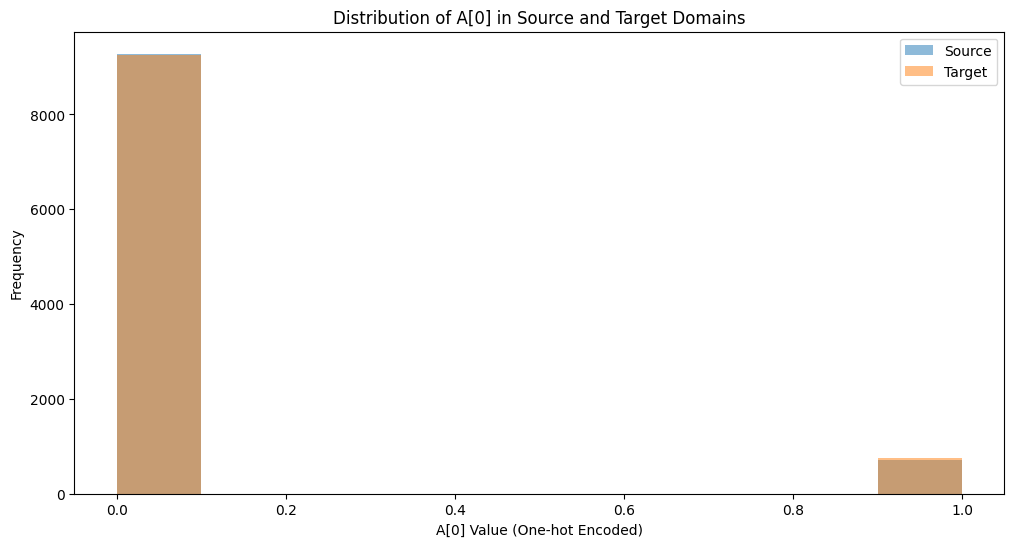

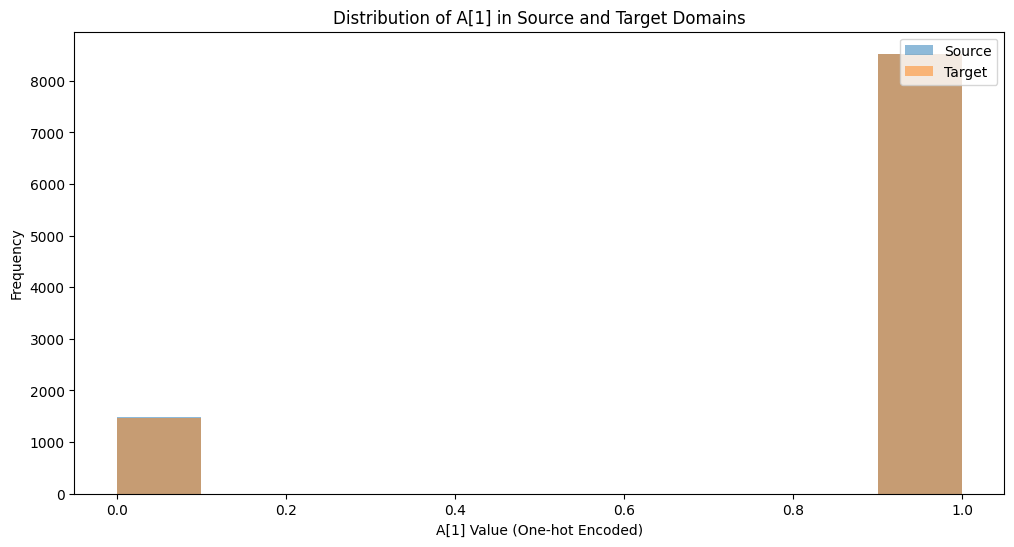

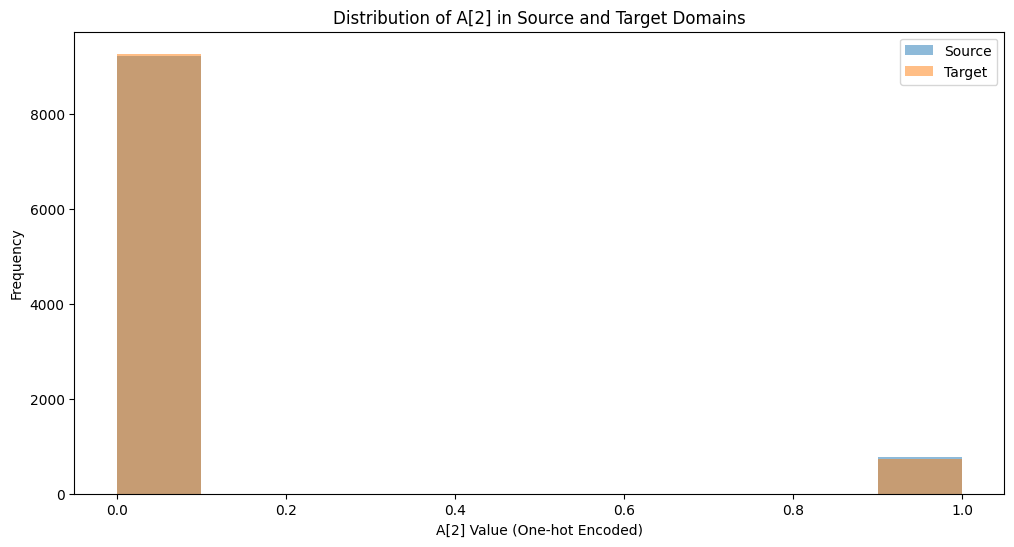

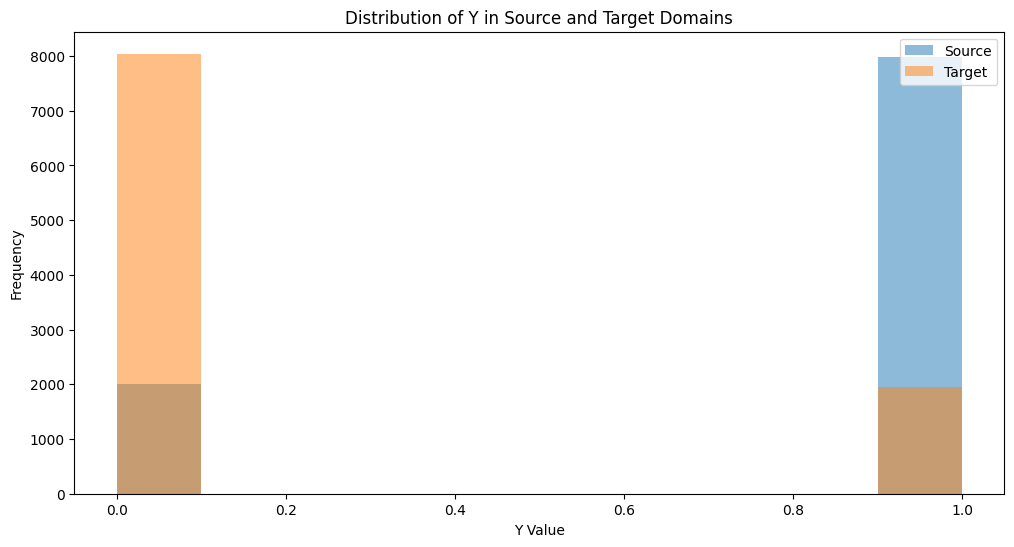

In [1271]:
def plot_histograms(source, target, title, bins=10, xlabel='Value', ylabel='Frequency'):
    plt.figure(figsize=(12, 6))
    plt.hist(source, bins=bins, alpha=0.5, label='Source')
    plt.hist(target, bins=bins, alpha=0.5, label='Target')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')
    plt.show()

# Convert lists of tensors to numpy arrays for plotting
Z_source_np = np.array([z.numpy() for z in Z_source])
Z_target_np = np.array([z.numpy() for z in Z_target])
W_source_np = np.array([w.numpy() for w in W_source])
W_target_np = np.array([w.numpy() for w in W_target])
A_source_np = np.array([a.numpy() for a in A_source])
A_target_np = np.array([a.numpy() for a in A_target])
Y_source_np = np.array([y.numpy() for y in Y_source])
Y_target_np = np.array([y.numpy() for y in Y_target])

# Plot Z
plot_histograms(
    Z_source_np[:, 1], Z_target_np[:, 1],  # Compare the one-hot encoded "1" position
    title='Distribution of Z in Source and Target Domains',
    xlabel='Z Value (One-hot Encoded)',
    ylabel='Frequency'
)

# Plot W
plot_histograms(
    W_source_np[:, 1], W_target_np[:, 1],
    title='Distribution of W in Source and Target Domains',
    xlabel='W Value (One-hot Encoded)',
    ylabel='Frequency'
)

# Plot A (flatten for multi-class)
for i in range(A_source_np.shape[1]):
    plot_histograms(
        A_source_np[:, i], A_target_np[:, i],
        title=f'Distribution of A[{i}] in Source and Target Domains',
        xlabel=f'A[{i}] Value (One-hot Encoded)',
        ylabel='Frequency'
    )

# Plot Y
plot_histograms(
    Y_source_np, Y_target_np,
    title='Distribution of Y in Source and Target Domains',
    xlabel='Y Value',
    ylabel='Frequency'
)


In [1272]:
from scipy.stats import ks_2samp

def perform_ks_test(source, target, feature_name):
    statistic, p_value = ks_2samp(source, target)
    print(f"KS Test for {feature_name}: statistic={statistic}, p-value={p_value}")

perform_ks_test(Z_source_np[:, 1], Z_target_np[:, 1], 'Z')
perform_ks_test(W_source_np[:, 1], W_target_np[:, 1], 'W')
for i in range(A_source_np.shape[1]):
    perform_ks_test(A_source_np[:, i], A_target_np[:, i], f'A[{i}]')
perform_ks_test(Y_source_np, Y_target_np, 'Y')

KS Test for Z: statistic=0.4569, p-value=0.0
KS Test for W: statistic=0.4681, p-value=0.0
KS Test for A[0]: statistic=0.0024, p-value=1.0
KS Test for A[1]: statistic=0.0014, p-value=0.9999999999999993
KS Test for A[2]: statistic=0.0038, p-value=0.9999996477853529
KS Test for Y: statistic=0.6028, p-value=0.0


/var/folders/tf/g242212x4tsbkxq6k9xkfvn80000gn/T/ipykernel_32114/3858282105.py:4: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  statistic, p_value = ks_2samp(source, target)


In [1270]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# BASELINE METHODS #

In [ ]:
###### COVARIATE SHIFT #####

In [ ]:
"""Implementation of covariate shift adaptation method. """

# Author: Nicole Chiou <nicchiou@stanford.edu>, Katherine Tsai <kt14@illinois.edu>
# MIT License


import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn import random_projection as r_proj


def convert_data_y2d(source, target):
    source_y = np.zeros_like(source["Y"])
    target_y = np.ones_like(target["Y"])

    return {
        "X": np.concatenate([source["X"], target["X"]], axis=0),
        "Y": np.concatenate([source_y, target_y], axis=0).ravel(),
    }


class COVAR:
    """Covariate shift adaptation."""

    def __init__(self, alpha=1.0, kernel="rbf", proj_dim=16):
        self.source_covar_model = KernelRidge(alpha=alpha, kernel=kernel)
        self.target_covar_model = KernelRidge(alpha=alpha, kernel=kernel)
        self.proj_dim = proj_dim

    def fit(self, source_train, target_train):
        domain_d = convert_data_y2d(source_train, target_train)
        proj = r_proj.GaussianRandomProjection(
            n_components=self.proj_dim, random_state=0
        ).fit(domain_d["X"])
        d_x = LogisticRegression(random_state=0)
        d_x.fit(proj.transform(domain_d["X"]), domain_d["Y"])

        # Compute sample weights
        q_x_train = d_x.predict_proba(proj.transform(source_train["X"]))[:, 1]
        source_sample_weight_train = q_x_train / (1.0 - q_x_train + 1e-3)

        # Fit source model
        self.source_covar_model.fit(
            source_train["X"],
            source_train["Y"],
            sample_weight=source_sample_weight_train,
        )

        # Compute sample weights
        q_x_train = d_x.predict_proba(proj.transform(target_train["X"]))[:, 0]
        target_sample_weight_train = q_x_train / (1.0 - q_x_train + 1e-3)

        # Fit target model
        self.target_covar_model.fit(
            target_train["X"],
            target_train["Y"],
            sample_weight=target_sample_weight_train,
        )

    def predict(self, test_data):
        return self.source_covar_model.predict(test_data["X"])

    def predict_target(self, test_data):
        return self.target_covar_model.predict(test_data["X"])

In [ ]:
print(len(Z_source))
print(len(Y_source))
print(len(Z_train_source))
print(len(Y_train_source))

10000
10000
6000
6000


In [ ]:
np.array([tensor.item() for tensor in Y_test_source]).astype(int).sum()

1672

In [ ]:
source_train = {"X": Z_train_source, "Y": Y_train_source}
target_train = {"X": Z_train_target, "Y": Y_train_target}
test_data = {"X": Z_test_source}

In [ ]:
# Initialize the model
covar_model = COVAR(alpha=1.0, kernel="rbf", proj_dim=16)

# Fit the model to the training data
covar_model.fit(source_train, target_train)

# Make predictions on the test data from the source domain
predictions = covar_model.predict(test_data)

print("Predictions using source model:", predictions)

/Users/rickcollins64/opt/anaconda3/envs/MV00/lib/python3.9/site-packages/sklearn/random_projection.py:409: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (2 < 16).The dimensionality of the problem will not be reduced.
  warnings.warn(


Predictions using source model: [0.93372129 0.43652572 0.82862557 ... 0.93372129 0.80515792 0.43652572]


In [ ]:
# convert probabilities to predictions
predictions_source_covar = (predictions >= 0.5).astype(int)

binary_labels_test_source_covar = np.array([tensor.item() for tensor in Y_test_source]).astype(int)

print(predictions_source_covar)
print(binary_labels_test_source_covar)

[1 0 1 ... 1 1 0]
[1 0 1 ... 1 1 1]


Accuracy of model on target training set: 0.8580
Classification Report for Z:
              precision    recall  f1-score   support

           0       0.57      0.54      0.55       328
           1       0.91      0.92      0.92      1672

    accuracy                           0.86      2000
   macro avg       0.74      0.73      0.73      2000
weighted avg       0.85      0.86      0.86      2000



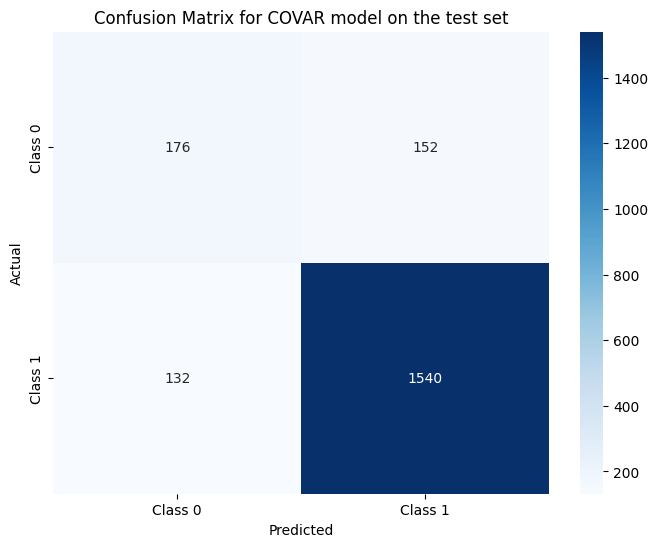

In [ ]:
# Predict on the target domain training set using the target model
# Z_train_pred_source = covar_model.predict_target({"X": Z_train_target})

# Assuming binary_labels_target_array_Z contains the true labels for Z_train_target
accuracy_covar = np.mean(binary_labels_test_source_covar == predictions_source_covar)
print(f"Accuracy of model on target training set: {accuracy_covar:.4f}")

# Compute confusion matrix and classification report
cm_covar_source = confusion_matrix(binary_labels_test_source_covar, predictions_source_covar)
print("Classification Report for Z:")
print(classification_report(binary_labels_test_source_covar, predictions_source_covar))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_covar_source, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for COVAR model on the test set')
plt.show()

In [ ]:
# LABEL SHIFT #

In [ ]:
"""Implementation of label shift adaptation method."""

# Author: Nicole Chiou <nicchiou@stanford.edu>, Katherine Tsai <kt14@illinois.edu>
# MIT License


import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import normalize
import cvxpy as cp
import scipy


class ConLABEL:
    """
    Continuous label shift adaptation.

    Zhang, K., Schölkopf, B., Muandet, K., & Wang, Z. (2013, May).
    Domain adaptation under target and conditional shift.
    In International conference on machine learning (pp. 819-827). PMLR.
    """

    def __init__(self, lam, bp, alpha, kernel, kernel2):
        self.lam = lam
        self.bp = bp
        self.kernel = kernel
        self.label_model = KernelRidge(alpha=alpha, kernel=kernel2)

    def fit(self, source_data, target_x):

        # Learn the weight
        K_Y = self.kernel(source_data["Y"], source_data["Y"])

        K_X = self.kernel(source_data["X"], source_data["X"])
        m1 = K_X.shape[0]

        inv_KY = scipy.linalg.solve(K_Y + self.lam * np.eye(m1), np.eye(m1))
        inv_KY_KY = np.einsum("ij,jk->ik", inv_KY, K_Y)

        K_X1X2 = self.kernel(source_data["X"], target_x)
        m2 = K_X1X2.shape[1]
        A = inv_KY_KY.T @ K_X @ inv_KY_KY

        B = K_X1X2.T @ inv_KY_KY
        B = (m1 / m2) * B
        B = np.sum(B, axis=0)
        G = np.eye(m1)
        G2 = -np.eye(m1)
        x = cp.Variable(m1)
        h = self.bp * np.ones(m1)
        h2 = np.zeros(m1)
        C = np.ones(m1)
        eps = self.bp * np.sqrt(m1) / 4
        print("start fitting")
        prob = cp.Problem(
            cp.Minimize((1 / 2) * cp.quad_form(x, A) + B.T @ x),
            [G @ x <= h, G2 @ x <= h2, C @ x <= eps + m1, -C @ x <= -m1 + eps],
        )

        prob.solve()
        print("finished")
        print(f"Problem status {prob.status}")
        beta = np.array(x.value)
        idx = np.where(beta < 0)[0]
        beta[idx] = 0
        beta = normalize(beta[:, np.newaxis]).squeeze()
        self.label_model.fit(
            source_data["X"],
            source_data["Y"],
            sample_weight=beta,
        )

    def predict(self, test_data):
        return self.label_model.predict(test_data)


class LABEL:
    """
    implementation of label shift adaptation method.
    """

    def __init__(self, alpha, kernel="rbf", kernel2="gaussian", bandwidth=1):
        self.source_kde = KernelDensity(kernel=kernel2, bandwidth=bandwidth)
        self.target_kde = KernelDensity(kernel=kernel2, bandwidth=bandwidth)

        self.source_label_model = KernelRidge(alpha=alpha, kernel=kernel)
        self.target_label_model = KernelRidge(alpha=alpha, kernel=kernel)

    def fit(self, source_train, source_val, target_train):
        self.source_kde.fit(source_val["Y"])
        self.target_kde.fit(target_train["Y"])

        # Compute sample weights q(Y)/p(Y)
        log_q_y = self.target_kde.score_samples(source_train["Y"])
        log_p_y = self.source_kde.score_samples(source_train["Y"])

        source_sample_weight_train = np.exp(log_q_y - log_p_y)

        # Fit source model
        self.source_label_model.fit(
            source_train["X"],
            source_train["Y"],
            sample_weight=source_sample_weight_train,
        )

        # Compute sample weights p(Y)/q(Y)
        target_sample_weight_train = np.exp(log_p_y - log_q_y)

        # Fit target model
        self.target_label_model.fit(
            target_train["X"],
            target_train["Y"],
            sample_weight=target_sample_weight_train,
        )

    def predict(self, test_data):
        return self.source_label_model.predict(test_data["X"])

    def predict_target(self, test_data):
        return self.target_label_model.predict(test_data["X"])

In [ ]:
# Prepare the data (ensure your data is correctly formatted)
source_train = {"X": Z_train_source, "Y": Y_train_source}
source_val = {"Y": Y_val_source}
target_train = {"X": Z_train_target, "Y": Y_train_target}
test_data_source = {"X": Z_test_source}
binary_labels_test_source = np.array([tensor.item() for tensor in Y_test_source])

# Reshape Y values to 2D arrays
source_val["Y"] = source_val["Y"].reshape(-1, 1)
target_train["Y"] = target_train["Y"].reshape(-1, 1)
source_train["Y"] = source_train["Y"].reshape(-1, 1)
binary_labels_test_source = binary_labels_test_source.reshape(-1, 1)

# Initialize the LABEL model
label_model = LABEL(alpha=1.0, kernel="rbf", kernel2="gaussian", bandwidth=1)

# Fit the model to the training data
label_model.fit(source_train, source_val, target_train)

# Get the predicted probabilities from the LABEL model on the source domain test data
prob_predictions_source = label_model.predict(test_data_source)
# Convert probabilities to class labels using a threshold of 0.5
predictions_source = (prob_predictions_source >= 0.5).astype(int)
print("Predictions using LABEL model on source test data:", predictions_source)

# Ensure both are the same data type for comparison
binary_labels_test_source = binary_labels_test_source.astype(int)

# Evaluate the LABEL model on the source domain test data
accuracy_label = accuracy_score(binary_labels_test_source, predictions_source)
print(f"Accuracy of LABEL model on source test data: {accuracy_label:.4f}")

# Compute confusion matrix and classification report for LABEL model
cm_label_source = confusion_matrix(binary_labels_test_source, predictions_source)
print("Classification Report for LABEL model on source test data:")
print(classification_report(binary_labels_test_source, predictions_source))

# Plot the confusion matrix for LABEL model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_label_source, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LABEL model on source test data')
plt.show()

AttributeError: 'list' object has no attribute 'reshape'